In [1]:
import sys
import os
from pathlib import Path
sys.path.append(os.getcwd().replace("notebooks","utils"))

from co2_functions import Clustering
import general_purpose as gp
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder, OneHotEncoder
from sklearn.metrics import silhouette_samples,silhouette_score
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
from tqdm import tqdm
from yellowbrick.cluster import KElbowVisualizer
import seaborn as sns

Hey!, el módulo co2 ha sido importado correctamente 🥳
Módulo General Listo Para Usarse 💻


In [2]:
df = gp.dataframes_charger("df_v3.csv")
df.head()

,GDP,Population,Energy_production,Energy_consumption,CO2_emission,per_capita_production,Energy_intensity_by_GDP,balance,eficiency,energy_dependecy,use_intensity_pc,co2_pc,latitude,longitude,Year,Country,Energy_type,CODE_x,continent
0,279.389,15182.60,0.150,0.155,0.0,104.341,5.670,-0.005,0.0,0.001,0.0,0.0,6.424,-66.59,1980-01-01,Venezuela,renewables_n_other,VEN,South America
1,279.389,15182.60,5.000,0.812,0.0,104.341,5.670,4.188,0.0,0.003,0.0,0.0,6.424,-66.59,1980-01-01,Venezuela,petroleum_n_other_liquids,VEN,South America
2,279.389,15182.60,0.616,0.616,0.0,104.341,5.670,0.000,0.0,0.002,0.0,0.0,6.424,-66.59,1980-01-01,Venezuela,natural_gas,VEN,South America
3,279.389,15182.60,0.001,0.002,0.0,104.341,5.670,-0.000,0.0,0.000,0.0,0.0,6.424,-66.59,1980-01-01,Venezuela,coal,VEN,South America
4,278.376,15597.88,0.156,0.161,0.0,110.257,6.178,-0.005,0.0,0.001,0.0,0.0,6.424,-66.59,1981-01-01,Venezuela,renewables_n_other,VEN,South America


Vamos a realizar la clusterización de nuestros países. En primer lugar, vamos a realizarlo con todas las variables posibles y vamos a ver que resultados nos ofrece K-means. Para ello, primero vamos a estandarizar las variables numéricas, ya que K-Means trabaja mejor con variables que tengan una escala similar y después vamos a codificar las variables no numéricas para poder usarlas en el modelo:

In [3]:
# escalamos las variables numéricas con StandardScaler:
scaler = StandardScaler()
scaler.fit(df.select_dtypes(exclude="object").drop(["latitude","longitude"],axis=1))
scaled_vars = scaler.transform(df.select_dtypes(exclude="object").drop(["latitude","longitude"],axis=1))
scaled_vars

array([[-0.44034817, -0.39419771, -0.39014896, ..., -0.06483716,
        -0.04567602, -0.04933498],
       [-0.44034817, -0.39419771,  0.448528  , ..., -0.06163021,
        -0.04567602, -0.04933498],
       [-0.44034817, -0.39419771, -0.30956681, ..., -0.06323368,
        -0.04567602, -0.04933498],
       ...,
       [-0.52774252, -0.3335616 , -0.41555422, ..., -0.04864109,
        -0.04567602, -0.04772854],
       [-0.52774252, -0.3335616 , -0.41502101, ..., -0.05259654,
        -0.04567602, -0.04772854],
       [-0.52774252, -0.3335616 , -0.2634832 , ..., -0.01600859,
        -0.04567602, -0.04451568]])

In [4]:
scaled_vars.shape

(6484, 12)

In [5]:
encoder = LabelEncoder().fit(df.Energy_type)
vars_encoded = encoder.transform(df.Energy_type)

In [6]:
# Probamos usando OHE pero nuestra variable energy type si que tiene peso entre
# variables y obtenemos mejores resultados con StandardScaler o un mapeado

# ohe = OneHotEncoder().fit(df.Energy_type.values.reshape(-1,1))
# ohe_vars = ohe.transform(df.Energy_type.values.reshape(-1,1))
# ohe_df = pd.DataFrame(ohe_vars.toarray(),columns=ohe.get_feature_names_out())

# dejamos de usar ohe porque nos clasifica casi el dataset entero en una sola 
# categoría aún cuando clasifica en más de una y obtenemos mejores resultados con Labelencoder

In [6]:
# las unimos para poder usarlas:
df_procesed = pd.DataFrame(scaled_vars,columns=scaler.get_feature_names_out())
df_procesed["energy_type"] = vars_encoded
df_procesed.head()

,GDP,Population,Energy_production,Energy_consumption,CO2_emission,per_capita_production,Energy_intensity_by_GDP,balance,eficiency,energy_dependecy,use_intensity_pc,co2_pc,energy_type
0,-0.440348,-0.394198,-0.390149,-0.337429,-0.274557,-0.317403,-0.104399,-0.079812,-0.110894,-0.064837,-0.045676,-0.049335,4
1,-0.440348,-0.394198,0.448528,-0.228110,-0.274557,-0.317403,-0.104399,1.386236,-0.110894,-0.061630,-0.045676,-0.049335,3
2,-0.440348,-0.394198,-0.309567,-0.260723,-0.274557,-0.317403,-0.104399,-0.078064,-0.110894,-0.063234,-0.045676,-0.049335,1
3,-0.440348,-0.394198,-0.415915,-0.362887,-0.274557,-0.317403,-0.104399,-0.078064,-0.110894,-0.066441,-0.045676,-0.049335,0
4,-0.440686,-0.392674,-0.389111,-0.336431,-0.274557,-0.283269,0.003849,-0.079812,-0.110894,-0.064837,-0.045676,-0.049335,4


# K-Means

In [7]:
# vamos a realizar la primera clusterización con todas las variables a ver cuantos clusters obtenemos:
clustering = KMeans()
clustering.fit(df_procesed)
prediction = clustering.predict(df_procesed)
clusters1 = np.unique(prediction,return_counts=True)
pd.DataFrame({"clusters":clusters1[0],"num_paises":clusters1[1]})

,clusters,num_paises
0,0,2875
1,1,374
2,2,661
3,3,3
4,4,162
5,5,2387
6,6,15
7,7,7


En el dataframe anterior, vemos como se han clasificado los diferentes países en cada cluster, sin embargo al tener los mismos países en diferentes años, los países variarán de cluster en función del año en que se encontraran.

In [8]:
clustering.cluster_centers_.shape

(8, 13)

In [9]:
np.unique(prediction)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [13]:
# Los representamos a través de dos variables representativas de este estudio:
px.scatter(data_frame=df_procesed,
            x="Energy_production",
            y="CO2_emission",
            color=prediction.astype("str"),
            template="plotly_dark",
            size=df.GDP,
            title="First Glance Production-CO2-GDP")

Antes de nada, vamos a ver si los clusters que se han generado son los óptimos, para ello vamos a ver la inercia que se genera en cada cluster. Es decir, vamos a ver la suma de los cuadrados de cada punto a su centroide para un rango de n clusters y establecer en que número de clusters la inercia empieza a decrecer en menor proporción de lo que lo venía haciendo, de tal manera que podamos tener un criterio a la hora de establecer cual podría ser un número de clusters idóneo. A partir de ese punto, la información captada por cada cluster, y por tanto la diferenciación de uno y otro, empieza a no ser significativa.

In [16]:
# calculamos la distorsión para un rango de de clusters:
inertia = []
for i in np.arange(1,10):
    km = KMeans(n_clusters=i).fit(df_procesed)
    inertia.append(km.inertia_)
# ahora dibujamos las difrentes distorsiones o inercias:
px.line(x= np.arange(1,10), y= inertia,markers=True,title="K-Means Inertia",\
        labels=dict(x="clusters",y="inertia")).add_vline(x=4,line_color="green")


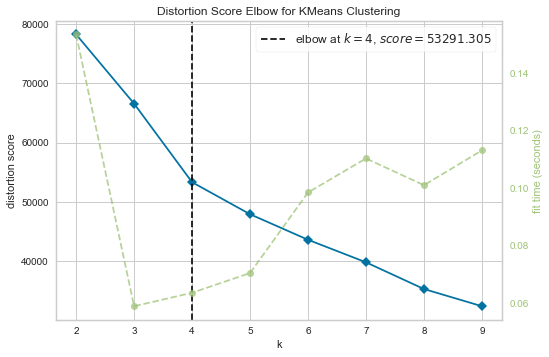

In [14]:
visualizer = KElbowVisualizer(KMeans(),k=(2,10)).fit(df_procesed)
visualizer.show();

k = 4 parece ser el óptimo debido a que el incremento del número de clusters desde 4 hasta 5 obtiene una reducción de la inercia significativamente menor que desde 3 hasta 4, y además la diferencia en la reducción de la inercia desde 5 hasta 6 no es mucho mayor que la de 4 hasta 5. Es decir, la disminución porcentual de la inercia conforme vamos aumentando los cluster va siendo cada vez menor hasta llegar a un punto en que no exista. De esta manera, podemos decir que estimar la inercia para un cluster solo no es suficiente para poder determinar si estamos escogiendo los clusters óptimos, dado que no podemos comparar, y cuanto mayor es k menor es la inercia.
Por tanto, al revisar nuestro supuesto de partida, en el que queríamos que nuestros países se clasificaran en poco contaminantes, contaminantes y muy contaminantes. Al no estar muy alejados de nuestra idea inicial, hemos decidido que a la vista de los resultados vamos ha añadir una nueva categoría a nuestro modelo inicial y los vamos a dividir en:
* poco contaminantes
* contaminación moderada
* contaminantes
* muy contaminantes

In [178]:
clustering2 = KMeans(n_clusters=4,random_state=1234)
clustering2.fit(df_procesed)
prediction2 = clustering2.predict(df_procesed)
clusters2 = np.unique(prediction2,return_counts=True)
resumen1 = pd.DataFrame({"clusters":clusters2[0],"num_datos":clusters2[1]})
resumen1

,clusters,num_datos
0,0,3481
1,1,2798
2,2,3
3,3,202


In [179]:
px.scatter(data_frame=df_procesed,x="Energy_production",y="CO2_emission",color=prediction2)

Como apreciamos en el gráfico. Los paises quedan clasificados de la siguiente manera:
* poco contaminantes se corresponde con el cluster 0
* contaminación moderada se corresponde con el cluster 1
* contaminantes se corresponde con el cluster 3
* muy contaminantes se corresponde con el cluster 2

In [13]:
prueba = df_procesed[["CO2_emission","Energy_production"]]

### VAMOS A REALIZAR ALGUNAS PRUEBAS ADICIONALES PARA VER SI CORROBORAMOS LAS CONCLUSIONES ANTERIORES

In [14]:
# Usaremos solamente dos de las variables más representativas de nuestro estudio
prueba.head()

,CO2_emission,Energy_production
0,-0.274557,-0.390149
1,-0.274557,0.448528
2,-0.274557,-0.309567
3,-0.274557,-0.415915
4,-0.274557,-0.389111


In [15]:
clustering3 = KMeans()
clustering3.fit(prueba)
prediction3 = clustering3.predict(prueba)
prediction3

array([0, 5, 0, ..., 0, 0, 0], dtype=int32)

In [16]:
datas3 = np.unique(prediction3,return_counts=True)
pd.DataFrame({"clusters":datas3[0],"num_paises":datas3[1]})


,clusters,num_paises
0,0,4193
1,1,90
2,2,6
3,3,105
4,4,536
5,5,1456
6,6,10
7,7,88


In [17]:
px.scatter(data_frame=prueba,x="Energy_production",y="CO2_emission",color=prediction)

In [18]:
pd.DataFrame({"pais":prueba.index,"cluster":prediction}).sort_values(by="cluster")

,pais,cluster
6483,6483,0
4933,4933,0
4929,4929,0
4928,4928,0
4925,4925,0
...,...,...
3446,3446,7
3486,3486,7
3436,3436,7
3441,3441,7


Vemos que usando solo dos variables nos realiza los mismos cluster por defecto, veamos si el optimo sigue siendo cuatro con esas dos variables:

In [19]:
inertia = []
for i in np.arange(1,16):
    km = KMeans(n_clusters=i).fit(prueba)
    inertia.append(km.inertia_)
# ahora dibujamos las difrentes distorsiones o inercias:
px.line(x= np.arange(1,16), y= inertia,markers=True,title="K-Means Inertia",\
        labels=dict(x="clusters",y="inertia")).add_vline(x=3,line_color="green")

En este caso, podemos ver que el óptimo se ha desplazado hacia 3 y por lo tanto si para realizar los cluster solo usamos la producción de energía y el co2 emitido, podríamos mantener nuestra clasificación original.

In [20]:
clustering4 = KMeans(n_clusters=3,random_state=1234)
clustering4.fit(prueba)
prediction4 = clustering4.predict(prueba)
datas4 = np.unique(prediction4,return_counts=True)
resumen2 = pd.DataFrame({"clusters":datas4[0],"num_datos":datas4[1]})
resumen2

,clusters,num_datos
0,0,6186
1,1,15
2,2,283


In [21]:
print(resumen1)
print(resumen2)

   clusters  num_datos
0         0       3481
1         1       2798
2         2          3
3         3        202
   clusters  num_datos
0         0       6186
1         1         15
2         2        283


Vemos que en líneas generales lo que ha pasado es que el cluster 0 y el 1 se han fusionado. Establecimos que el cero eran los países poco contaminantes y los 1 con contaminación moderada. En este caso quedarían todos como poco contaminantes. Vamos a probar con otra combinación de variables que pensamos puede ser interesante:

In [16]:
prueba2 = df_procesed[["eficiency","Energy_production","energy_type"]]

inertia = []
for i in np.arange(1,16):
    km = KMeans(n_clusters=i).fit(prueba2)
    inertia.append(km.inertia_)
# ahora dibujamos las difrentes distorsiones o inercias:
fig = px.line(x= np.arange(1,16), y= inertia,markers=True,title="K-Means Inertia",\
        labels=dict(x="clusters",y="inertia")).add_vline(x=4,line_color="green")

clustering5 = KMeans(n_clusters=4,random_state=1234)
clustering5.fit(prueba2)
prediction5 = clustering5.predict(prueba2)
datas5 = np.unique(prediction5,return_counts=True)
resumen5 = pd.DataFrame({"clusters":datas5[0],"num_paises":datas5[1]})
fig.show()

In [23]:
resumen5

,clusters,num_paises
0,0,3375
1,1,2842
2,2,7
3,3,260


Pasa prácticamente lo mismo que en el primer caso, añade un cluster adicional, que es el de los países moderadamente contaminantes. La diferencia es que con estas tres variables los cambios de inercia son más acusados y se distinguen los cluster de manera más visual. Es decir las inercias de un número de clusters a otro son mayores y por tanto nos da a entender que sí que hay una diferencia importante entre los cluster y que el óptimo general sea 4 clusters.

> **En principio, según el modelo realizado con K-Means lo ideal son cuatro categorías de países divididos en poco contaminantes, moderadamente contaminantes, contaminantes y muy contaminantes**

Vemos que con todas las variables hemos clasificado de manera diferente los países que usando el modelo de 2 variables, o el de 3 variables. Por esto, para saber que modelo es el mejor debemos recordar que el clustering es un método de machine learning no supervisado, y por tanto no tenemos acceso a saber la verdad de fondo de estas clasificaciones, o lo que es lo mismo, no sabemos, como en la clasificación, el resultado real para cada conjunto de datos de las variables dadas. Por tanto, es difícil, si no imposible, determinar que el modelo con solo 2 variables es más acertado que el que las incluye a todas, o viceversa. En otras palabras, qué modelo, o que variables, deberíamos escoger viene determinado por otra información externa que se nos provee por otros departamentos, dentro de una empresa.  
Vamos a realizar una última prueba, denominada silueta, con la cual vamos a confirmar si nuestra elección ha sido acertada o no:

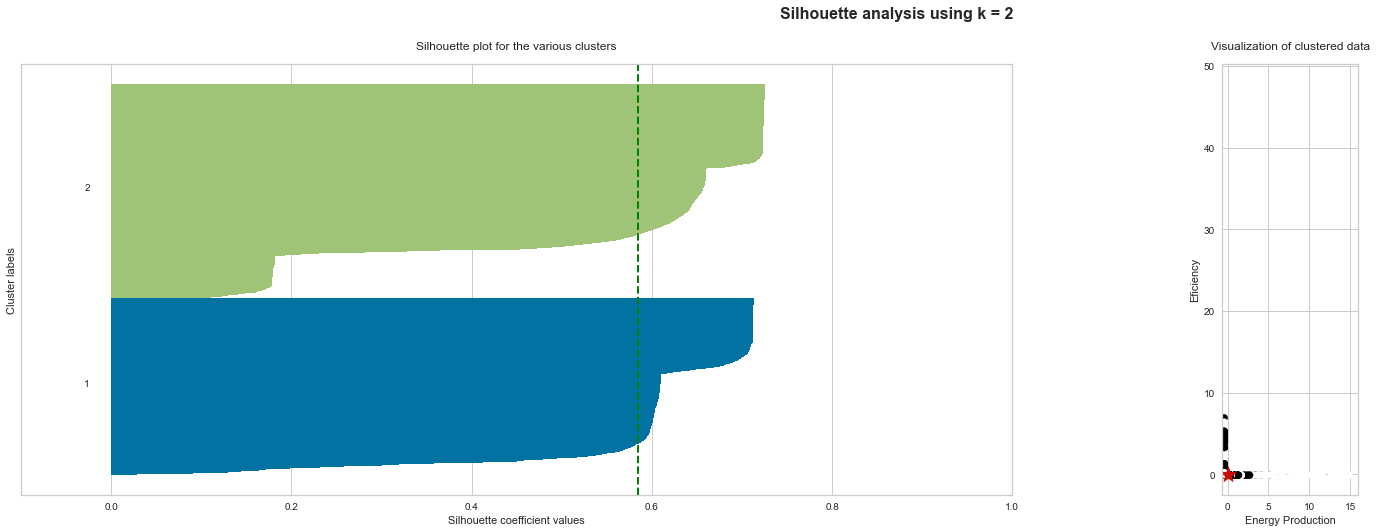

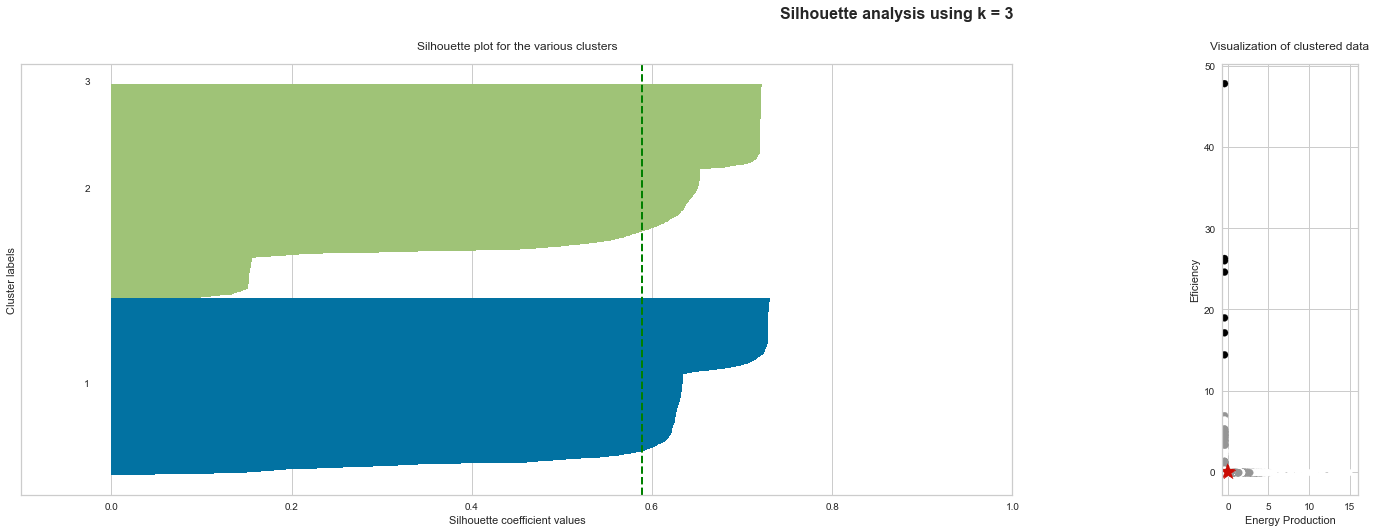

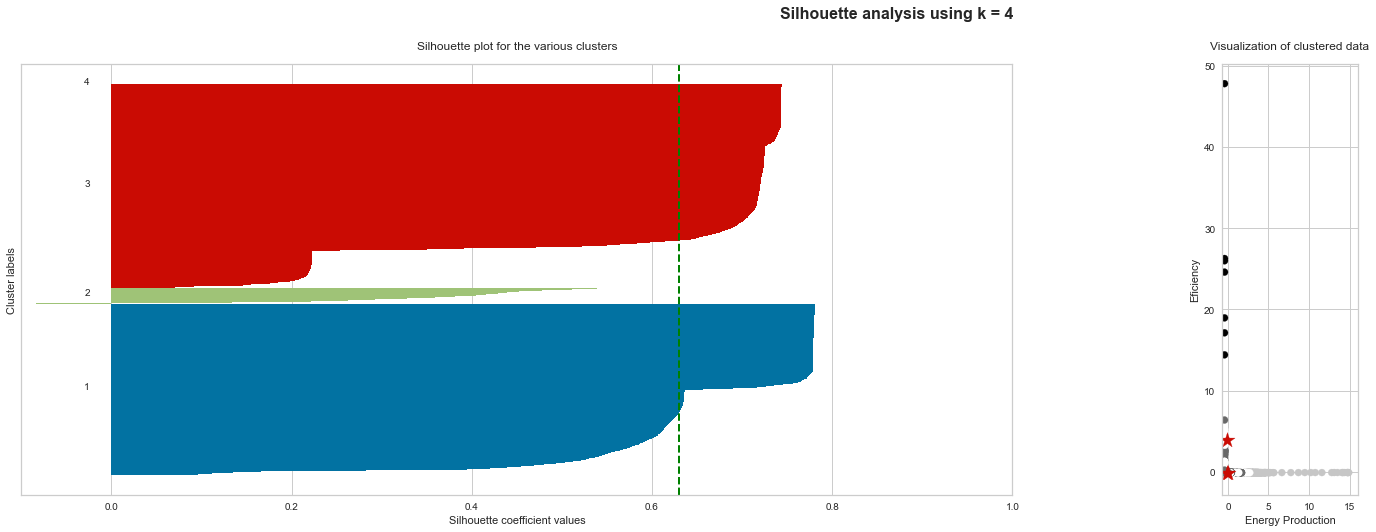

In [18]:
# Gráfico de silueta con tres variables eficiency, energy production y energy_type:
for i, k in enumerate([2, 3, 4]):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(25, 7)
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k,random_state=0)
    labels = km.fit_predict(prueba2)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(prueba2, labels)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for the various clusters', y=1.02);

    # Scatter plot of data colored with labels
    ax2.scatter(prueba2.loc[:, "Energy_production"], prueba2.loc[:,"eficiency"], c=labels)
    ax2.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='r', s=250)
    ax2.set_xlim([-0.7, 16])
    ax2.set_xlim([-0.7, 16])
    ax2.set_xlabel('Energy Production')
    ax2.set_ylabel('Eficiency')
    ax2.set_title('Visualization of clustered data', y=1.02)
    ax2.set_aspect('equal')
    plt.tight_layout(w_pad=0.001)
    plt.suptitle(f'Silhouette analysis using k = {k}',
                    fontsize=16, fontweight='semibold', y=1.05)
plt.show()

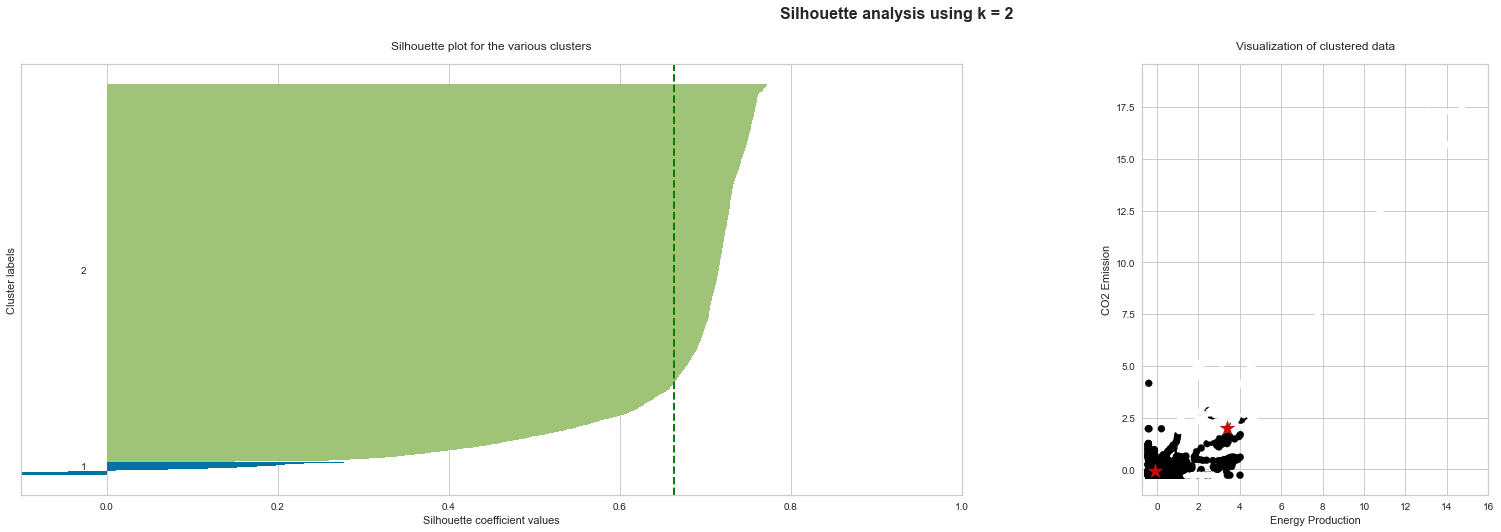

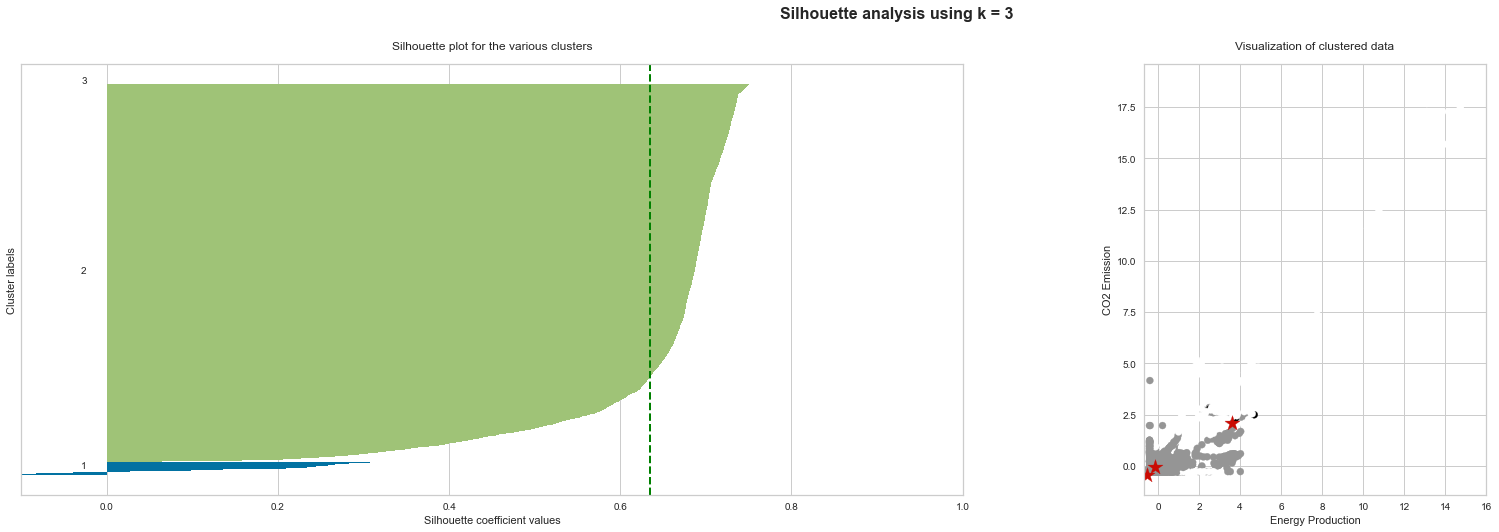

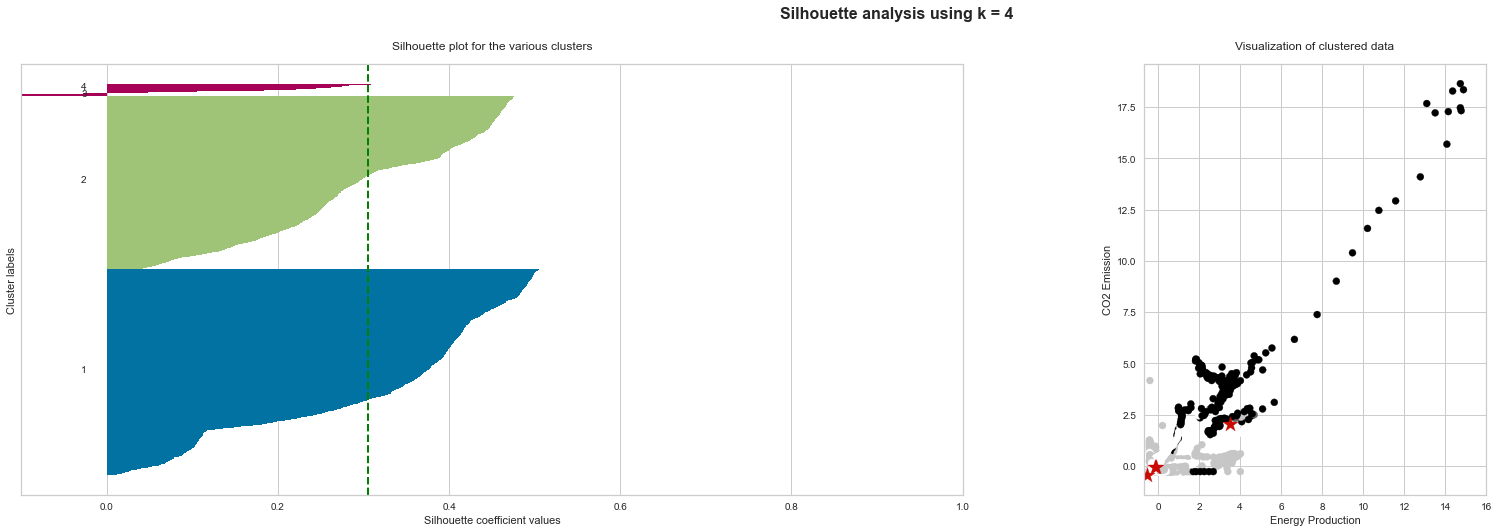

In [19]:
# Gráfico de silueta con todas las variables
for i, k in enumerate([2, 3, 4]):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(25, 7)
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k,random_state=0)
    labels = km.fit_predict(df_procesed)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(df_procesed, labels)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for the various clusters', y=1.02);

    # Scatter plot of data colored with labels
    ax2.scatter(df_procesed.loc[:, "Energy_production"], df_procesed.loc[:,"CO2_emission"], c=labels)
    ax2.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='r', s=250)
    ax2.set_xlim([-0.7, 16])
    ax2.set_xlim([-0.7, 16])
    ax2.set_xlabel('Energy Production')
    ax2.set_ylabel('CO2 Emission')
    ax2.set_title('Visualization of clustered data', y=1.02)
    ax2.set_aspect('equal')
    plt.tight_layout(w_pad=0.001)
    plt.suptitle(f'Silhouette analysis using k = {k}',
                    fontsize=16, fontweight='semibold', y=1.05)
plt.show()

Como nos muestran los gráficos de silueta, el número de cluster óptimo, si atendemos solamente a la media del score serían dos clusters, ya que tiene un 0.7 sobre 0.3 de los demás. Sin embargo, no todos los clusters en este primero están por encima de esa media en el score. Esto último tampoco ocurre para 3 clusters y por tanto, si hubiera igualdad de score con el de 4 clusters, el cual sí que tiene todos sus clusters por encima de 0.3, sería preferible a 2 clusters y 3 clusters. Vemos que la mayoría de nuesttros datos se incluirían en la categoría de moderadamente contaminantes y contaminante y el resto en los extremos opuestos, que serían poco contaminantes y muy contaminantes. Sin embargo, la conclusión que podemos sacar de esta última prueba es que aunque el número de clusters 4 ofrece el mejor compromiso entre el score general y el individual entre cada cluster, no podemos decir que Kmeans esté haciendo un buen trabajo en la clasificación, debido a que el score medio es muy bajo, aunque sí que todos los clusters están por encima de este score medio. En este sentido un score medio que empiece a ser bueno para esta medida debería de estar por encima  de 0.5. Por eso vamos a probar con otro algoritmo de clasificación, que no intente agrupar los valores en una forma esférica, por su naturaleza de encontrar los valores más cercanos al centroide,y que por tanto cuando los valores tienen una forma diferente tenga un mejor desempeño. En resúmen, para considerar que la clusterización es buena se tiene que cumplir que:
1. El score medio de la silueta general sea superior a 0.5
2. que la silueta de todos los clusters tengan un score medio superior al general.

Vamos a probar con el modelo DBSCAN:
# DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

DBSCAN es un algoritmo de clusterización basado en la densidad y por tanto asume que los clusters son regiones densas de datos en el espacio que están separados unos de otros por regiones menos densas de ellos. De esta manera, los datos agrupados densamente entre ellos son combinados en un cluster. Podemos identificar clusters en grandes datasets si observamos la densidad local de los datos.
Una característica única de la clusterización con DBSCAN es que maneja muy bien los outliers, debido a lo cual es aplicado en sistemas de detección de anomalias. Por otra parte, una de sus principales características, y que nos sirve en este caso según las conclusiones obtenidas con K-Means, es que puede detectar clusters que son complejos o que tienen una forma y tamaño aleatoria.


En principio probamos con los valores por defecto de DBSCAN:  
- eps = 0.5  
- min_samples = 5  
- metric = euclidean

In [8]:
db = DBSCAN().fit(df_procesed)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Silhouette Coefficient: %0.3f" % silhouette_score(df_procesed, labels))

Estimated number of clusters: 67
Estimated number of noise points: 473
Silhouette Coefficient: -0.001


y podemos ver que la clasificación es muy mala, tenemos un coeficiente de silueta realmente malo y 67 clusters que son demasiados. Dejandonos como ruido 473 datos, que son datos que han quedado fuera de los cluster sin ser asignados,y que para el tamaño del dataset no se me hace elevado, y me hace pensar que dado el número de clusters obtenidos y el ruido generado, no vamos a mejorar mucho la clusterización. Pero vamos a ver cuanto podemos mejorar esto:

In [9]:
clusters = []
noise = []
sil_coef = []
eps = []
for i in np.linspace(0.1,1,10):
    db = DBSCAN(eps=i).fit(df_procesed)

    # Number of clusters in labels, ignoring noise if present.
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    clusters.append(n_clusters_)
    noise.append(n_noise_)
    sil_coef.append(silhouette_score(df_procesed,labels))
    eps.append(i)
print("--------- eps = %0.5f ----------"% eps[sil_coef.index(max(sil_coef))])
print("Estimated number of clusters: %d" % clusters[sil_coef.index(max(sil_coef))])
print("Estimated number of noise points: %d" % noise[sil_coef.index(max(sil_coef))])
print("Silhouette Coefficient: %0.3f" % max(sil_coef))

--------- eps = 1.00000 ----------
Estimated number of clusters: 35
Estimated number of noise points: 132
Silhouette Coefficient: 0.109


Mirando solo el eps, que es el valor más importante en DBSCAN, en un rango de 0.1 a 1 hemos encontrado que el número de clusters optimo son 35, con un ruido de 132 datos y un coeficiente de silueta que está muy lejos de ser bueno aún. Vamos a ampliar un poco más el eps y después pasaremos al minPts:

In [10]:
clusters = []
noise = []
sil_coef = []
eps = []
for i in np.linspace(0.1,2,20):
    db = DBSCAN(eps=i).fit(df_procesed)

    # Number of clusters in labels, ignoring noise if present.
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    clusters.append(n_clusters_)
    noise.append(n_noise_)
    sil_coef.append(silhouette_score(df_procesed,labels))
    eps.append(i)
print("--------- eps = %d ----------"% eps[sil_coef.index(max(sil_coef))])
print("Estimated number of clusters: %d" % clusters[sil_coef.index(max(sil_coef))])
print("Estimated number of noise points: %d" % noise[sil_coef.index(max(sil_coef))])
print("Silhouette Coefficient: %0.3f" % max(sil_coef))

--------- eps = 1 ----------
Estimated number of clusters: 13
Estimated number of noise points: 55
Silhouette Coefficient: 0.336


Hemos mejorado bastante, pero aún estamos lejos de un buen dato para el coeficiente de silueta. Ahora mismo tenemos un coeficiente de silueta muy parecido a nuestro k-means pero con 13 clusters y esto no podemos considerarlo una mejora, ampliamos aún más el rango de eps:

In [102]:
clusters = []
noise = []
sil_coef = []
eps = []
for i in tqdm(np.linspace(0.1,10,100)):
    db = DBSCAN(eps=i).fit(df_procesed)

    # Number of clusters in labels, ignoring noise if present.
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    clusters.append(n_clusters_)
    noise.append(n_noise_)
    sil_coef.append(silhouette_score(df_procesed,labels))
    eps.append(i)
print(f"--------- eps = {eps[sil_coef.index(max(sil_coef))]} ----------")
print("Estimated number of clusters: %d" % clusters[sil_coef.index(max(sil_coef))])
print("Estimated number of noise points: %d" % noise[sil_coef.index(max(sil_coef))])
print("Silhouette Coefficient: %0.3f" % max(sil_coef))

100%|██████████| 100/100 [02:04<00:00,  1.24s/it]

--------- eps = 9.2 ----------
Estimated number of clusters: 1
Estimated number of noise points: 7
Silhouette Coefficient: 0.920


In [103]:
px.scatter(data_frame=df_procesed,x="Energy_production",y="CO2_emission",color=db.labels_)

Parece que hemos encontrado una solución mejor con un eps = 9.2, ahora tenemos 1 cluster con un ruido bastante pequeño y un coeficiente de silueta bastante bueno de 0.92. Sin embargo, vemos que lo que está pasando es que el eps es tan grande que todos los posibles clusters están siendo integrados en uno solo, y de ahí esos buenos datos. Veamos qué datos obtuvimos para 3 clusters y para 4 clusters, que es nuestro objetivo:

In [104]:
for i in range(len(clusters)):
    if clusters[i] == 3 or clusters[i] == 4:
        print(f"--------- eps = {eps[i]} ----------")
        print("Estimated number of clusters: %d" % clusters[i])
        print("Estimated number of noise points: %d" % noise[i])
        print("Silhouette Coefficient: %0.3f" % sil_coef[i])
        print("="*20)

--------- eps = 3.4000000000000004 ----------
Estimated number of clusters: 4
Estimated number of noise points: 34
Silhouette Coefficient: 0.573
--------- eps = 3.5000000000000004 ----------
Estimated number of clusters: 4
Estimated number of noise points: 32
Silhouette Coefficient: 0.573
--------- eps = 3.8000000000000003 ----------
Estimated number of clusters: 4
Estimated number of noise points: 26
Silhouette Coefficient: 0.572
--------- eps = 3.9000000000000004 ----------
Estimated number of clusters: 4
Estimated number of noise points: 26
Silhouette Coefficient: 0.572
--------- eps = 4.0 ----------
Estimated number of clusters: 4
Estimated number of noise points: 26
Silhouette Coefficient: 0.572
--------- eps = 4.1 ----------
Estimated number of clusters: 4
Estimated number of noise points: 26
Silhouette Coefficient: 0.572
--------- eps = 4.2 ----------
Estimated number of clusters: 4
Estimated number of noise points: 26
Silhouette Coefficient: 0.572
--------- eps = 4.3 ----------

Aquí vemos que tenemos un coeficiente de silueta aceptable siendo los mayores  en eps = 3.4000000000000004 y eps = 3.5000000000000004 con 0.573 en ambos y un ruido de 34 y 32 respectivamente. Esta clasificación tiene más sentido y ayuda a confirmar a K-Means.Además, la clasificación de DBSCAN mejora la de K-means porque ahora tenemos un coeficiente de silueta general por encima de 0.5. Veamoslo representado en un scatterplot, y recordemos que no hemos tocado el parámetro minPts:

In [128]:
# representamos el mejor de ambos que en este caso es el que menor ruido tiene
db2 = DBSCAN(eps=3.5000000000000004).fit(df_procesed)
labels = db2.labels_
px.scatter(data_frame=df_procesed,x="Energy_production",y="CO2_emission",color=labels)

Para ver si hemos elegido bien vamos a utilizar el método del codo que usamos para k-means pero adaptado a DBSCAN, y vamos a ver que nos dice:

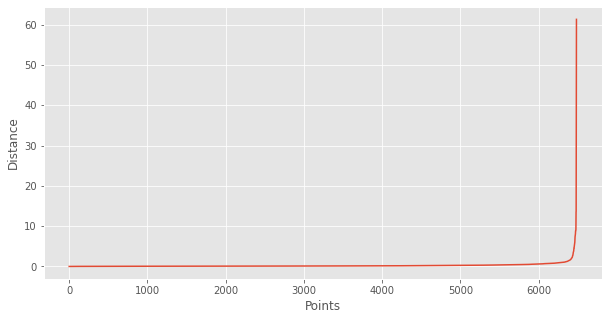

In [140]:
nearest_neighbors = NearestNeighbors(n_neighbors=5)
neighbors = nearest_neighbors.fit(df_procesed)

distances, indices = neighbors.kneighbors(df_procesed)
distances = np.sort(distances[:,4], axis=0)

fig = plt.figure(figsize=(10, 5))
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance")
plt.show()

Comprobamos que para cada uno de los puntos que tenemos se produce un cambio drástico en la pendiente de la curva por encima de los 6000 datos y que el eps estará en torno a 0 y 10, pero visualmente no podemos verlo, por lo que vamos a calcular el eps óptimo que coincidirá justo con el punto en el que la pendiente de la curva se hace máxima.

<Figure size 720x360 with 0 Axes>

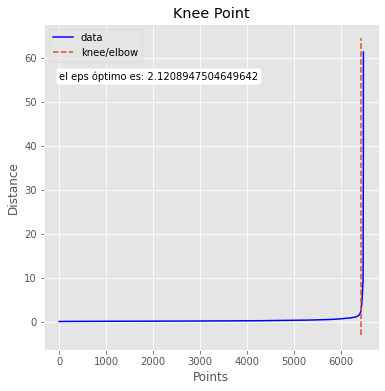

In [149]:
i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='interp1d')

fig = plt.figure(figsize=(10, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
plt.annotate(f"el eps óptimo es: {distances[knee.knee]}",xy=(0,55),bbox=dict(boxstyle="round",fc="1"))
plt.show()


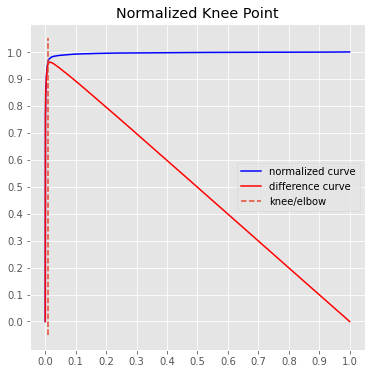

In [150]:
plt.style.use('ggplot')
knee.plot_knee_normalized()

In [151]:
db3 = DBSCAN(eps=distances[knee.knee]).fit(df_procesed)
labels = db3.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Silhouette Coefficient: %0.3f" % silhouette_score(df_procesed, labels))

Estimated number of clusters: 12
Estimated number of noise points: 47
Silhouette Coefficient: 0.300


Podemos ver que para un número mínimo de datos de 5, como iniciamos nuestro estudio, el eps óptimo sería de 2.12 aproximadamente y nos daría un número de clusters de 12, que es demasiado. Por tanto no nos sirve esta clasificación, además el coeficiente de silueta es más bajo que anteriormente con un eps de 4. Vamos a probar con diferentes números de datos mínimos y ver cual nos da mejor eps.

In [121]:
clusters2 = []
ruido = []
eps_opt = []
siluete_score = []
min_datos = []
for minpts in tqdm(range(5,200)):

    nearest_neighbors = NearestNeighbors(n_neighbors=minpts)
    neighbors = nearest_neighbors.fit(df_procesed)

    distances, indices = neighbors.kneighbors(df_procesed)
    distances = np.sort(distances[:,minpts-1], axis=0)
    i = np.arange(len(distances))
    knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='interp1d')

    db4 = DBSCAN(eps=distances[knee.knee],min_samples=minpts).fit(df_procesed)
    labels = db4.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    pts = distances[knee.knee]
    
    siluete_score.append(silhouette_score(df_procesed,labels))
    eps_opt.append(pts)
    ruido.append(n_noise_)
    clusters2.append(n_clusters_)
    min_datos.append(minpts)

100%|██████████| 195/195 [42:23<00:00, 13.04s/it]   


In [152]:
# los diferentes clusters que hemos obtenido han sido:
np.unique(clusters2)

array([ 1,  2,  3,  4,  6, 11, 12])

Vemos que tenemos un rango de clusters que va desde 1 hasta 12,variando el número mínimo de puntos que debe contener cada cluster, y usando el mejor eps asociado a él. Ahora vamos a ver los datos para los casos en que tenemos 3 y 4 clusters:

In [123]:
for i in range(len(clusters2)):
    if clusters2[i] == 3 or clusters2[i] == 4:
        print(f"n.clusters: {clusters2[i]}")
        print(f"eps: {eps_opt[i]}")
        print(f"siluete: {siluete_score[i]}")
        print(f"ruido: {ruido[i]}")
        print(f"minPts: {min_datos[i]}")
        print("|"*30)

n.clusters: 4
eps: 3.176005889262874
siluete: 0.605381743153619
ruido: 47
minPts: 9
||||||||||||||||||||||||||||||
n.clusters: 3
eps: 3.0569169572587787
siluete: 0.5981449256015536
ruido: 60
minPts: 11
||||||||||||||||||||||||||||||
n.clusters: 3
eps: 3.428380653336865
siluete: 0.5982389428498142
ruido: 53
minPts: 12
||||||||||||||||||||||||||||||
n.clusters: 3
eps: 3.5007070155929942
siluete: 0.5989134897632981
ruido: 54
minPts: 15
||||||||||||||||||||||||||||||
n.clusters: 3
eps: 3.643601622672541
siluete: 0.5989806978711474
ruido: 53
minPts: 17
||||||||||||||||||||||||||||||


En relación a los mejores datos que obtuvimos antes podemos ver la siguiente tabla:

|medida|antes elbow|después elbow|
|------|-----------|-------------|
|clusters|        4|            4|
|eps   |        3.6|3.176005889262874|
|siluete|     0.574|0.605381743153619|
|ruido|          32|           47|
|min_samples|     5|           9|

Por lo que podemos concluir que, ambos resultados son muy parecidos, y por tanto, si usaramos todas las variables elegiríamos el modelo resultado de la prueba elbow con iteración sobre los puntos mínimos que se muestra en la tabla (después elbow), que mejora el coeficiente de silueta. A igualdad de resultados, DBSCAN obtiene mejores valores de coeficiente de silueta. Veamos, como nos queda DBSCAN con dos variables

In [55]:
db_prueba = DBSCAN(eps=3.176005889262874,min_samples=9).fit(df_procesed)
np.unique(db_prueba.labels_)

array([-1,  0,  1,  2,  3], dtype=int64)

In [57]:
colorines = db_prueba.labels_.astype("str")

In [59]:
px.scatter(data_frame=df_procesed,x="Energy_production",y="CO2_emission",
color=colorines,title="4 clusters usando todas las variables")

In [14]:
df_2var = df_procesed[["Energy_production","CO2_emission"]]

clusters2 = []
ruido = []
eps_opt = []
siluete_score = []
min_datos = []
for minpts in tqdm(range(5,200)):

    nearest_neighbors = NearestNeighbors(n_neighbors=minpts)
    neighbors = nearest_neighbors.fit(df_2var)

    distances, indices = neighbors.kneighbors(df_2var)
    distances = np.sort(distances[:,minpts-1], axis=0)
    i = np.arange(len(distances))
    knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='interp1d')

    db4 = DBSCAN(eps=distances[knee.knee],min_samples=minpts).fit(df_2var)
    labels = db4.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    pts = distances[knee.knee]
    
    siluete_score.append(silhouette_score(df_2var,labels))
    eps_opt.append(pts)
    ruido.append(n_noise_)
    clusters2.append(n_clusters_)
    min_datos.append(minpts)

for i in range(len(clusters2)):
    if clusters2[i] == 3 or clusters2[i] == 4:
        print(f"n.clusters: {clusters2[i]}")
        print(f"eps: {eps_opt[i]}")
        print(f"siluete: {siluete_score[i]}")
        print(f"ruido: {ruido[i]}")
        print(f"minPts: {min_datos[i]}")
        print("|"*30)

100%|██████████| 195/195 [06:38<00:00,  2.04s/it]

n.clusters: 4
eps: 0.3822635971298373
siluete: 0.8442511844074615
ruido: 30
minPts: 6
||||||||||||||||||||||||||||||
n.clusters: 3
eps: 0.4514428146821307
siluete: 0.8356223241356692
ruido: 36
minPts: 12
||||||||||||||||||||||||||||||
n.clusters: 3
eps: 0.473498042216855
siluete: 0.8357770948738025
ruido: 35
minPts: 13
||||||||||||||||||||||||||||||


In [60]:
db_2var = DBSCAN(eps=0.3822635971298373,min_samples=6).fit(df_2var)
colorines = db_2var.labels_.astype("str")
px.scatter(data_frame=df_2var,x="Energy_production",y="CO2_emission",
color=colorines,title="4 clusters usando 2 variables")

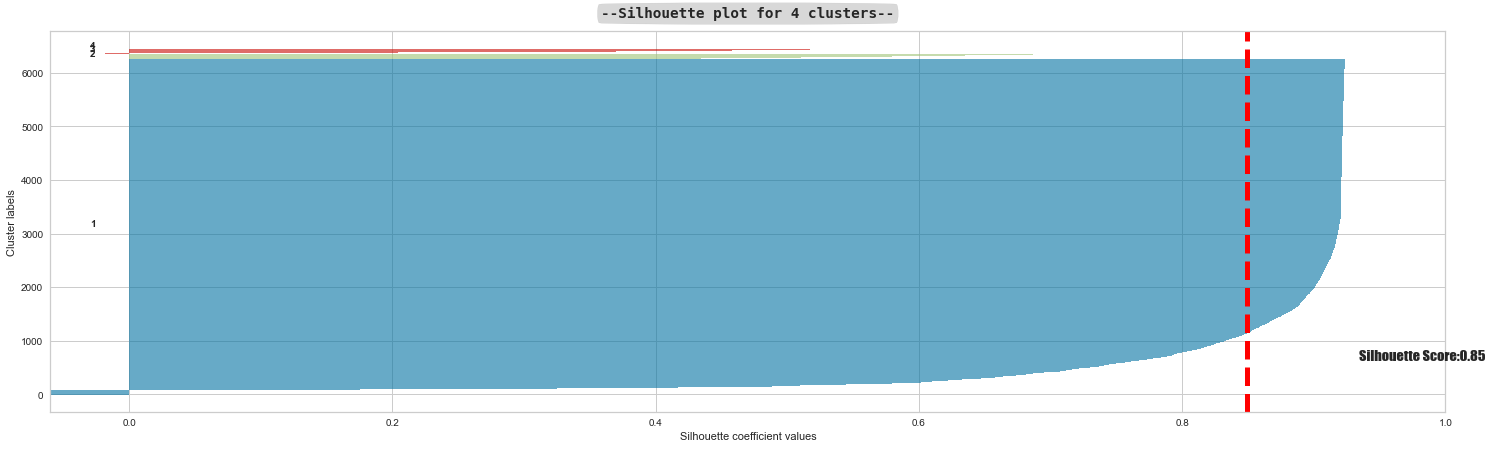

In [50]:
Clustering.grafico_silueta(df_2var,"d",radio=0.3822635971298373,minpts=6)

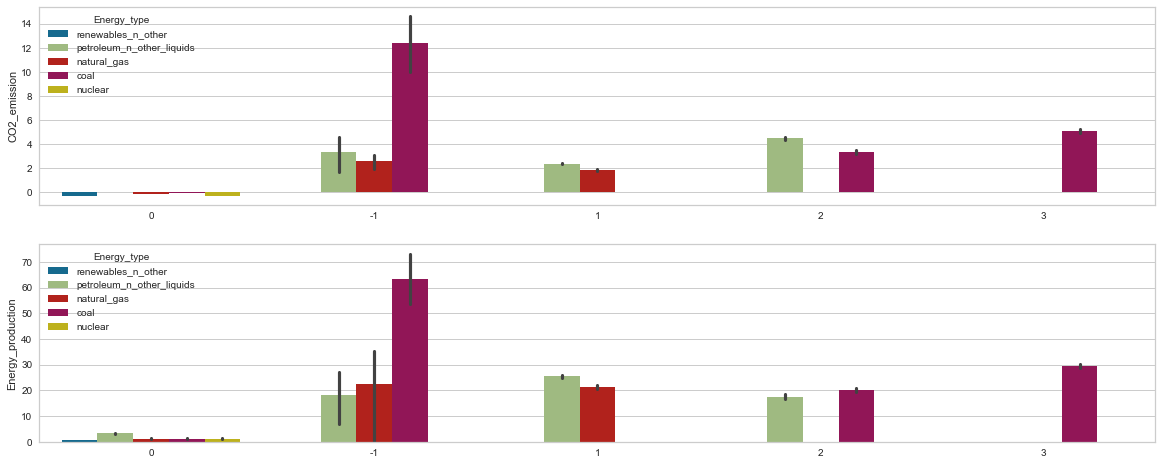

In [53]:
fig,ax = plt.subplots(2,1,figsize=(20,8))
sns.barplot(data=df_2var,x=db_2var.labels_.astype("str"),y="CO2_emission",hue=df.Energy_type,ax=ax[0])
sns.barplot(x=db_2var.labels_.astype("str"),y=df.Energy_production,hue=df.Energy_type,ax=ax[1])
plt.show()

Podemos ver que usando solo las dos variables más representativas del estudio, llegamos a una solución de 4 clusters bien definidos con un coeficiente de silueta medio de 0.85 que es muy bueno y mejor que todos los anteriores. Sin embargo, es debido a que el cluster más grande, el 0, pesa mucho en la media pues está muy bien definido. Por el contrario, el resto de clusters no están tan bien definidos los unos de los otros, y en consecuencia no superan al score medio. En este sentido, los clusters están caracterizados por las siguientes cualidades:

* Cluster 0: Es el más numeroso de todos, pues es donde se encuentran la mayoría de los datos, y son países que tienen la producción de energía más pequeña, pero también las emisiones de co2 más pequeñas. Al tener un mix de generación de energía muy diversificado pueden llegar a tener emisiones de co2 negativas, pues usan las 4 energías.
* Cluster 1: Es el segundo más grande, y contiene a aquellos países con las segundas mayores producciones de energía por tipo de energía, basandose esta en petróleo y gas natural. Debido a que se basan en estos dos tipos de generación, sus emisiones de co2 también son las segundas menores de los clusters.
* Cluster 2: Este cluster es muy parecido al anterior, sin embargo es menos numeroso, y su diferencia fundamental es que la producción está basada sobre todo en carbón junto con el petróleo. Su producción es la tercera más grande y sus emisiones de co2 son mayores que el cluster anterior. Es curioso que, produciendo menos energía mediante petóleo que el cluster anterior, emiten más co2 que ellos. Esto puede ser debido a que usan procesos de producción menos eficientes.
* Cluster 3: El cluster 3 es el más pequeño de todos y son países que solo producen mediante el carbón, emitiendo más co2 que las demás tecnologías

El cluster -1 es el ruido del modelo, o aquellos datos que no han podido ser asignados a ningún cluster. Vemos que se caracterizan por ser países con producciones muy elevadas por cada tipo de energía usada, basandose fundamentalmente en el carbón, el gas natural y el petróleo. Dadas estas características aquí tendremos una proporción grande de datos de China, Estados Unidos y Rusia.

# LA CONCLUSIÓN LA TOMAMOS EN LA PARTE 2 DE LA CLUSTERIZACIÓN